In [22]:
run '../__init__.py'

In [23]:
import numpy as np
import networkx as nx
import cvxpy as cp

# import warnings
# warnings.filterwarnings("ignore")

## Networkx Simple Example

In [24]:
G = nx.Graph()

In [25]:
G.add_nodes_from(['A', 'B', 'C', 'D', 'E'])

In [26]:
edges = [('A', 'B'), ('A', 'C'), ('A', 'D'), ('A', 'E')]
for e in edges:
    G.add_edge(*e)

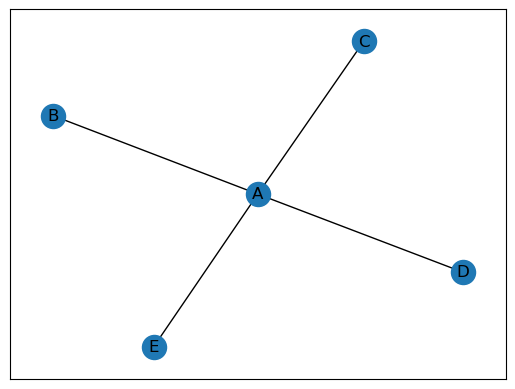

In [27]:
nx.draw_networkx(G)

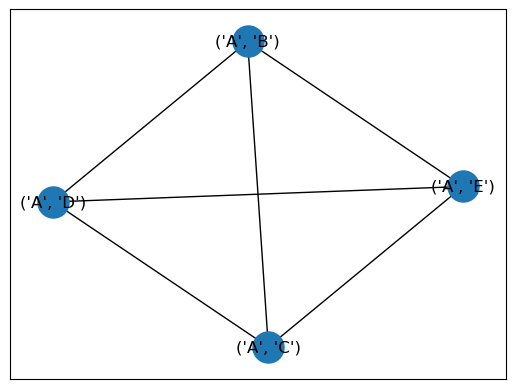

In [28]:
# Dual graph holy
G_prime=nx.line_graph(G)
nx.draw_networkx(G_prime, node_size=500)

In [29]:
L = nx.laplacian_matrix(G).todense()
L_prime = nx.laplacian_matrix(G_prime).todense()

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [30]:
L_prime

matrix([[ 3, -1, -1, -1],
        [-1,  3, -1, -1],
        [-1, -1,  3, -1],
        [-1, -1, -1,  3]])

## CVXPY

Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [31]:
# F_in = np.random.randint(low=1, high=10, size=(4, 2))
F_in = np.array([[4, 8],
                 [0, 0],
                 [2, 0],
                 [5, 2]])
# F_out = np.random.randint(low=1, high=10, size=(4, 2))
F_out = np.array([[3, 2],
                  [5, 7],
                  [5, 0],
                  [0, 5]])
print(F_in.shape)

(4, 2)


In [32]:
omega_in = np.array([[1, 1], [0, 0], [1, 0], [1, 1]])
omega_out = np.array([[1, 1], [1, 1], [1, 0], [0, 1]])

In [33]:
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

In [34]:
F_in_c = cp.Variable((4, 2))
F_out_c = cp.Variable((4, 2))

In [35]:
# P = np.array([[1, 2],
#               [1, 1],
#               [4, 1],
#               [1, 1]])

P = cp.Variable((4, 2))

$$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2$$

In [36]:
expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))

$$\lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F$$

In [37]:
L_prime

matrix([[ 3, -1, -1, -1],
        [-1,  3, -1, -1],
        [-1, -1,  3, -1],
        [-1, -1, -1,  3]])

In [38]:
F_in

array([[4, 8],
       [0, 0],
       [2, 0],
       [5, 2]])

In [17]:
F_out

array([[3, 2],
       [5, 7],
       [5, 0],
       [0, 5]])

In [21]:
# F_in.T @ L_prime @ F_out

matrix([[-55, -22],
        [-34, -36]])

In [16]:
# expr3 = F_in @ L_prime @ F_out
# expr4 = F_out @ L_prime @ F_in

$$\lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F$$

In [17]:
expr5 = l3 * cp.atoms.norm(F_in - np.pad(F_in[:, 1:], pad_width=((0, 0),(0, 1))), p='fro')
expr6 = l4 * cp.atoms.norm(F_out - np.pad(F_out[:, 1:], pad_width=((0, 0),(0, 1))), p='fro')

In [18]:
# F_in - np.pad(F_in[:, 1:], pad_width=((0, 0),(0, 1)))

$$\lambda_5||\bar{F} - F||_F$$

In [19]:
expr7 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

Constraint 1: $F_c, \bar{F_c} > 0$

In [20]:
# Define the constraints
constraints = [
    F_in_c >= 0,  # Ensure each element of F_in_c is positive
    F_out_c >= 0  # Ensure each element of F_out_c is positive
    # assert for Parking matrix to be positive
]

In [21]:
# P + np.pad(F_in_c.value[:, 1:], pad_width=((0, 0), (1, 0))) - np.pad(F_out_c.value[:, 1:], pad_width=((0, 0), (1, 0)))

Minimize

In [22]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr5 + expr6 + expr7),
                     constraints=constraints)
problem.solve()

33.791094042457985

In [ ]:
problem.solve()

In [23]:
F_in_c.value

array([[4.00000002, 8.00000002],
       [3.59189026, 3.59189026],
       [2.00000032, 3.59189026],
       [4.99999991, 2.00000032]])

In [24]:
F_out_c.value

array([[2.99999997, 1.99999993],
       [5.00000002, 7.00000008],
       [5.00000002, 3.59189026],
       [3.59189026, 5.00000002]])